In [1]:
# Set all dependency and variable

# %load_ext tensorboard
import datetime
import numpy as np
import seaborn as sn
import pandas as pd
import sklearn.metrics
# from sklearn import metrics
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_preprocessing

from tensorflow.python.client import device_lib 
from tensorflow.keras import utils, layers, backend

from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import filters


print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8193366801060385127
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1720082161456857303
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9238530566488714471
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
# Check number of CPU and GPU that Tensorflow used\

print("Num CPUUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num CPUUs Available:  1
Num GPUs Available:  0


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 8

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [4]:
datagen = ImageDataGenerator(
#     rescale = 1./127.5,
    rescale = 1./255. ,
    rotation_range=45,
    # featurewise_center=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
#     preprocessing_function = preprocess,
    validation_split=0.25,
)

test_generator = ImageDataGenerator(
    rescale = 1./255. ,
    validation_split=0.25,
)


In [5]:
TRAINING_DIR = "dataset"
VALIDATION_DIR = "validation"
TEST_DIR = "dataset_kue_test_2"

print("Loading training data...\t\t", end='')
train_generator = datagen.flow_from_directory(
	  TRAINING_DIR,
  	target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True,
)

print("Loading validation data...\t\t", end='')
validation_generator = test_generator.flow_from_directory(
  	 TRAINING_DIR,
#     VALIDATION_DIR,
	  target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
)


Loading training data...		Found 638 images belonging to 8 classes.
Loading validation data...		Found 207 images belonging to 8 classes.


In [6]:

print("Loading testing data...\t\t", end='')
test_data = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Loading testing data...		Found 160 images belonging to 8 classes.


In [7]:
# train_images_7, train_labels_7 = train_generator[5]
# print(train_images_7.shape)
# print(train_labels_7.shape)

# plt.figure(figsize=(20, 20))

# for idx in range(16):
#     ax = plt.subplot(2, 4, idx + 1)
#     plt.imshow(keras_preprocessing.image.array_to_img(train_images_7[idx]))
#     plt.title(str(train_labels_7[idx]))
#     plt.axis('off')

# plt.show

In [13]:
class_names = []
for a in train_generator.class_indices:
    class_names.append(a)
print(class_names)

['kue_cenil', 'kue_clorot', 'kue_dadar_gulung', 'kue_klepon', 'kue_lapis', 'kue_lumpur', 'kue_mendut', 'kue_serabi']


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((8, 224, 224, 3), (8, 8))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'kue_cenil': 0, 'kue_clorot': 1, 'kue_dadar_gulung': 2, 'kue_klepon': 3, 'kue_lapis': 4, 'kue_lumpur': 5, 'kue_mendut': 6, 'kue_serabi': 7}


In [10]:
base_model = tf.keras.applications.MobileNetV2(
    IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
# base_model.summary()

In [11]:
input_layer = tf.keras.Input(shape=IMAGE_SHAPE)
# x = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)
x = base_model(input_layer, training=False)

#keras
# x = layers.GlobalAveragePooling2D()(x)

#fastai
# x1 = layers.GlobalAveragePooling2D()(x)
# x2 = layers.GlobalMaxPooling2D()(x)
# x = layers.Concatenate()([x1, x2])
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(512, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)

#sazzad
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)

#bimo
# x = layers.GlobalMaxPooling2D()(x)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.2)(x)

output_layer = layers.Dense(train_generator.num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

l_rate = 0.00001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate), metrics=['accuracy'])

model.summary()
# utils.plot_model(model, show_layer_names=True, show_shapes=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 8200

In [12]:
# Train the data

# %tensorboard --logdir logs
n_epoch = 100
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = data_prep.fit(train_generator,
#                     steps_per_epoch=len(train_generator), 
# #                     steps_per_epoch=100, 
#                     epochs=10, 
#                     validation_data = validation_generator, 
#                     validation_steps=len(validation_generator),
# #                     validation_steps=100,
# #                     batch_size=32,
#                     # verbose=1,
#                     # callbacks=[es_callback],
# #                     callbacks=[cm_callback],
#                     )

history = model.fit(train_generator,
                    epochs=n_epoch, 
                    validation_data = validation_generator, 
                    verbose=1,
                    # callbacks=[es_callback],
#                     callbacks=[cm_callback],
                    )

Epoch 1/100
80/80 [==============================] - 25s 315ms/step - loss: 3.0554 - accuracy: 0.1285 - val_loss: 2.1314 - val_accuracy: 0.1884
Epoch 2/100
80/80 [==============================] - 24s 295ms/step - loss: 2.6147 - accuracy: 0.1959 - val_loss: 1.8648 - val_accuracy: 0.2899
Epoch 3/100
80/80 [==============================] - 24s 295ms/step - loss: 2.3825 - accuracy: 0.2335 - val_loss: 1.6765 - val_accuracy: 0.3865
Epoch 4/100
80/80 [==============================] - 23s 285ms/step - loss: 2.2338 - accuracy: 0.2602 - val_loss: 1.5182 - val_accuracy: 0.5072
Epoch 5/100
80/80 [==============================] - 23s 288ms/step - loss: 2.0414 - accuracy: 0.3135 - val_loss: 1.3897 - val_accuracy: 0.5652
Epoch 6/100
80/80 [==============================] - 23s 289ms/step - loss: 1.9051 - accuracy: 0.3182 - val_loss: 1.2607 - val_accuracy: 0.6377
Epoch 7/100
80/80 [==============================] - 23s 285ms/step - loss: 1.8246 - accuracy: 0.3903 - val_loss: 1.1536 - val_accuracy:

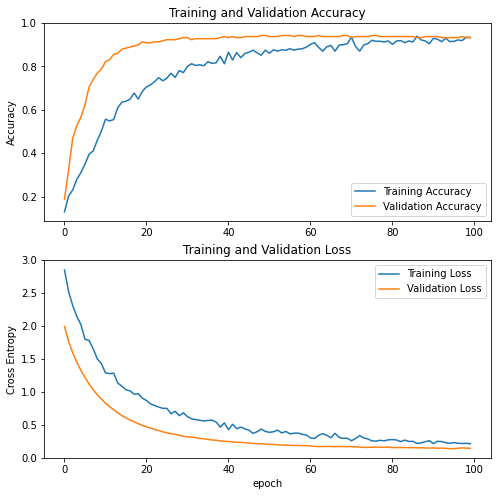

In [50]:
# Graph Before

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [22]:
print("Model evaluate:")
results = model.evaluate(test_data)

Model evaluate:
20/20 [==============================] - 3s 141ms/step - loss: 0.1646 - accuracy: 0.9438


In [51]:
print("Model evaluate:")
results = model.evaluate(test_data)

Model evaluate:
20/20 [==============================] - 3s 133ms/step - loss: 0.1453 - accuracy: 0.9625


Confusion Matrix
[[16  1  0  0  0  0  0  3]
 [ 0 18  1  0  1  0  0  0]
 [ 0  0 20  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0 20  0  0]
 [ 0  0  1  1  0  0 17  1]
 [ 0  0  0  0  0  0  0 20]]


<AxesSubplot:>

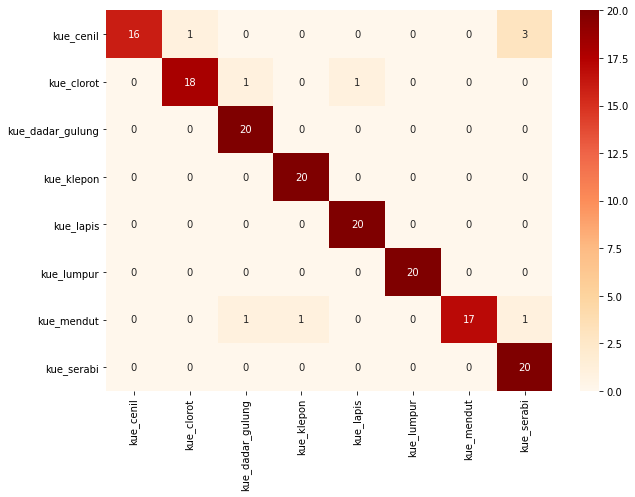

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[17  1  0  0  0  0  0  2]
 [ 0 19  0  0  1  0  0  0]
 [ 0  0 20  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0 20  0  0]
 [ 0  0  1  1  0  0 18  0]
 [ 0  0  0  0  0  0  0 20]]


<AxesSubplot:>

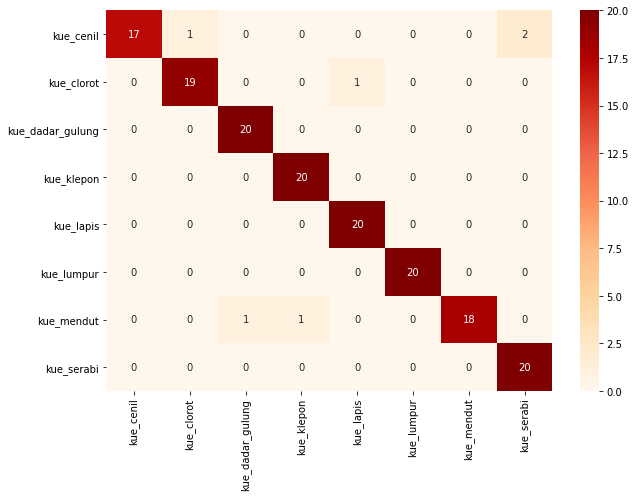

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(Y_pred, y_pred,
                                         pos_label=test_data.classes)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

ValueError: continuous-multioutput format is not supported

In [29]:
# from tensorflow import keras 
# from keras.utils import to_categorical

test_labels = test_data.classes
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=test_data.num_classes)

preds = np.round(model.predict(test_data),0)

classification_metrics = metrics.classification_report(test_labels, preds, target_names=class_names)
print(classification_metrics)

                  precision    recall  f1-score   support

       kue_cenil       1.00      0.80      0.89        20
      kue_clorot       1.00      0.90      0.95        20
kue_dadar_gulung       0.91      1.00      0.95        20
      kue_klepon       0.95      1.00      0.98        20
       kue_lapis       0.95      1.00      0.98        20
      kue_lumpur       1.00      1.00      1.00        20
      kue_mendut       1.00      0.85      0.92        20
      kue_serabi       0.87      1.00      0.93        20

       micro avg       0.96      0.94      0.95       160
       macro avg       0.96      0.94      0.95       160
    weighted avg       0.96      0.94      0.95       160
     samples avg       0.94      0.94      0.94       160



/home/bimo/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
import matplotlib.pyplot as plt

precision, recall = classification_metrics["precision"], classification_metrics["recall"]
plt.figure()
plt.step(recall, precision, where='post' )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()
plt.close()

TypeError: string indices must be integers

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix

# pred = model.predict(test_data)
# y_pred = tf.argmax(pred, 1) 
# plot_conf = confusion_matrix(test_data.classes, y_pred)
# plot_confusion_matrix(conf_mat=plot_conf)
# # prediction=tf.argmax(y,1)

# # res = tf.math.confusion_matrix(prediction,pred)
# # print('Confusion_matrix: ',res)

In [43]:
# x, y = test_data.next()
# print(x[7])
# print(np.where(y)[1][1])

In [44]:
# num_rows = 1
# num_cols = 8
# num_images = num_rows*num_cols
# plt.figure(figsize=(2*2*num_cols, 2*num_rows))    
    
# def plot_image2(i, predictions_array, true_label, img):
#   true_label, img = true_label[i], img[i]
#   wh = np.where(true_label)
#   npa = np.int64(wh[0]).astype(int)

#   predicted_label = np.argmax(predictions_array)

#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)
#   plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 ),
#              fontsize=16,
#              )

# def plot_image(i, predictions_array, true_label, img):
#   true_label, img = true_label[i], img[i]
#   wh = np.where(true_label)
#   npa = np.int64(wh[0]).astype(int)

#   predicted_label = np.argmax(predictions_array)

#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

#   plt.imshow(img, cmap=plt.cm.binary)
#   plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
#                                 100*np.max(predictions_array),
#                                 ),
#              fontsize=16,
#              )


# x, y = test_data.next()
# print(len(y))
# for isi in range(len(y)):
#     isi = isi - 1
#     hasil_predik = model.predict(x)
#     plt.subplot(num_rows, 2*num_cols, 2*i+1)
#     plot_image(isi, hasil_predik[isi], y, x)

# # for i in range(len(y)):
# #   predictions = model.predict(x)
# #   plt.subplot(num_rows, 2*num_cols, 2*i+1)
# #   plot_image(i-1, predictions[np.where(y)[1][i-1]], y, x)

# plt.tight_layout()
# plt.show()


In [45]:
# num_rows = 3
# num_cols = 6
# num_images = num_rows*num_cols
# plt.figure(figsize=(2*2*num_cols, 2*num_rows))


# def plot_image(i, predictions_array, true_label, img):
#   true_label, img = true_label[i], img[i]
#   wh = np.where(true_label)
#   npa = np.int64(wh[0]).astype(int)

#   predicted_label = np.argmax(predictions_array)


#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])

# #   plt.imshow(img, cmap=plt.cm.binary)
# #   plt.xlabel("{}".format(class_names[predicted_label],fontsize=16)

# x, y = test_data
# print(np.argmax(model.predict(x), axis=0))
# # for i in range(64):
# #   predictions = model.predict(x)
# #   print(predictions)
# #   plt.subplot(num_rows, 2*num_cols, 2*i+1)
# #   plot_image(i, np.argmax(predictions, axis=0), y, x)

# plt.tight_layout()
# plt.show()


# # - ambil gambar test
# # - prediksi
# # - bandingkan

IndexError: index 8 is out of bounds for axis 0 with size 8

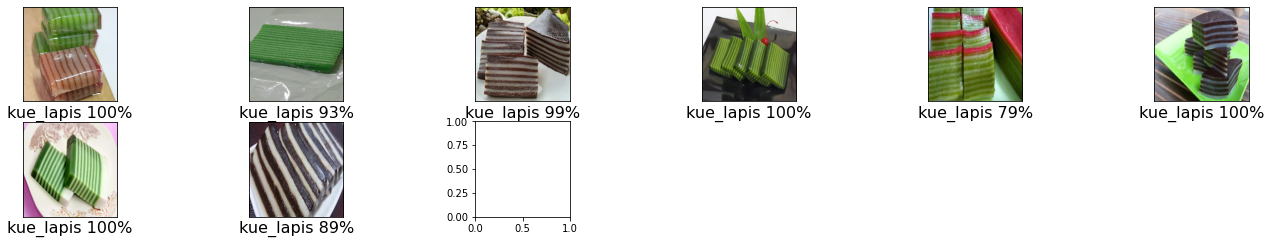

In [99]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)


  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()


IndexError: index 8 is out of bounds for axis 0 with size 8

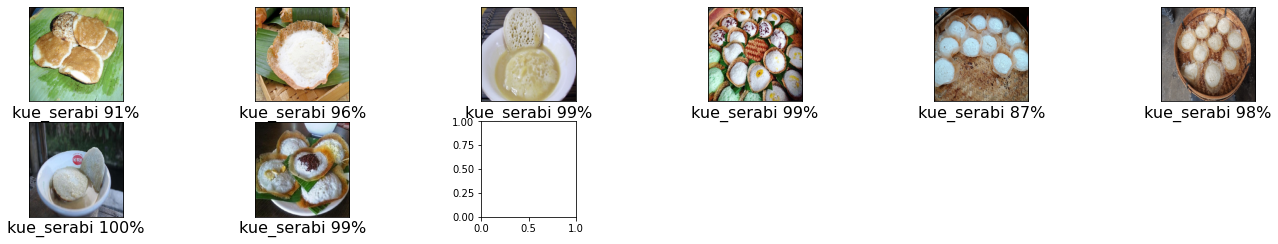

In [87]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)


  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()


In [ ]:
saved_model_dir = 'model_final'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model/14-7-21-p3/model.tflite', 'wb') as f:
  f.write(tflite_model)